# adVAE Tutorial: Generating Synthetic Gene Expression Profiles and MRI Images for Alzheimer's Disease


---

### Aim:

This tutorial demonstrates how to use `adVAE`, a variational autoencoder pipeline for generating synthetic gene expression data and MRI data. The tool can be applied to RNA microarray data as well as Gain-field corrected, atlas-registered average brain scans images from Alzheimer's Disease (AD) patients.

<br>


### Biological Question:

Can adVAE generate synthetic gene expression profiles and MRI images that retain biological characteristics of Alzheimer's gene expression patterns and MRI anatomical features associated with Alzheimer's Disease? Is this generated synthetic data useful for training classifier models that need to be trained on Alzheimer's-specific data?

<br>

### Dataset Used:

For the Gene Expression pipeline, I use a real RNA microarray dataset from the AMP-AD MSBB cohort, accessed via the AD Knowledge Portal.
- **Format**: RNA microarray expression values (.tsv)
- **Samples**: 20 brain samples from AD patients
- **Genes**: ~40,000 probes per sample
- **Preprocessing**: 
  - Remove duplicate values
  - Fill missing values
  - Aggregate by gene
  - Scale (Standard/MinMax)
  - PCA (retain 95% Variance)
- **Source**: [AD Knowledge Portal](https://adknowledgeportal.synapse.org/)

For the MRI pipeline, I use real MRI data from the OASIS-1 dataset, containing structural brain scans from cognitively abnormal and Alzheimer's-affected individuals.

- **Format**: Gain-field corrected, atlas-registered average brain scans images (.img) > tensor 
- **Samples**: ~100 subjects, 20 slices each
- **Preprocessing**:
  - Gain-field corrected, atlas-registered average MRI volumes 
  - Ensure proper orientation and extract 2D slices from 3D volumes
  - Standardize resolution to 128x128 pixels
  - Convert to grayscale tensors
  - Normalize intensities to [-1, 1]
- **Source:** [OASIS](https://sites.wustl.edu/oasisbrains/home/oasis-1/)

<br> 

### Installation:

Clone the repo and install dependencies.

```bash
git clone https://github.com/varnikaumashankar/adVAE.git
```

Alternatively, one can directly install the package without cloning the repo:

```bash
pip install dist/advae-0.1.0.tar.gz
```

<br>

### Environment Setup:

**1. Create conda environment:** Ensure that your system has conda installed. On your terminal, run: 
```bash
conda env create -f environment.yaml
```
**2. Activate conda environment:** Run:
```bash
conda activate adVAE
```
**3. Update dependencies in environment:** Run:
```bash
conda env update -f environment.yaml
```
**Package Module Structure:** Check package's module structure by running `python adVAE/utils/utils.py`.

<br>

### Running the Pipeline on CL:

Use `main.py` to run preprocessing, training, evaluation, or synthetic data generation for either pipeline.

```bash
python main.py --pipeline gene_expression --task preprocess
python main.py --pipeline gene_expression --task train
python main.py --pipeline gene_expression --task evaluate
python main.py --pipeline gene_expression --task visualize
python main.py --pipeline gene_expression --task generate
python main.py --pipeline gene_expression --task evaluate_synthetic

python main.py --pipeline mri --task preprocess
python main.py --pipeline mri --task train
python main.py --pipeline mri --task grid_search
python main.py --pipeline mri --task evaluate
python main.py --pipeline mri --task visualize
python main.py --pipeline mri --task generate
python main.py --pipeline mri --task evaluate_synthetic

```

All paths and parameters can be customized in `adVAE/config.py`.

<br>

### Note:

Due to limited data availability, the datasets were not split into the standard 70-20-10 training-validation-testing ratio as initially intended. As a result, model performance was evaluated directly on the training data, which may limit the generalizability of the results. Future iterations of this project will focus on incorporating proper validation and test splits to enable more rigorous performance assessment. This will be critical for building a more robust and generalizable VAE model capable of generating high-quality synthetic multimodal biomedical data. 

---

### Model Architecture:

**Gene Expression Pipeline:**

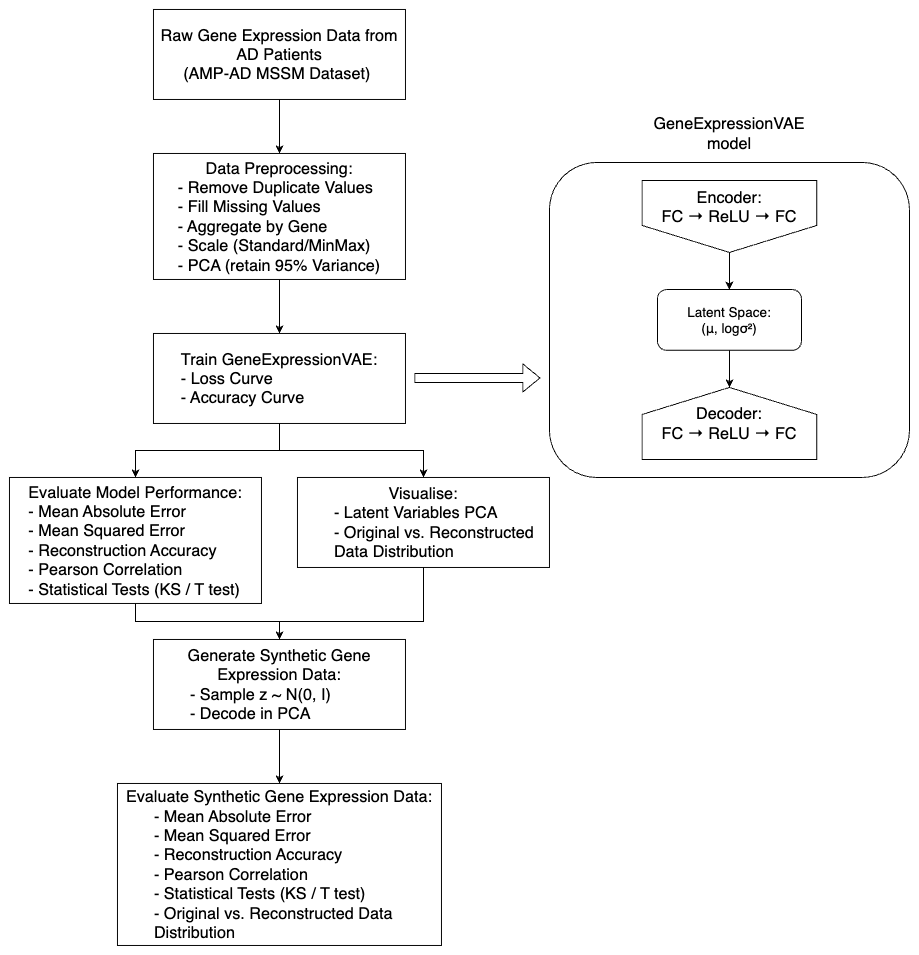

**MRI Pipeline:**

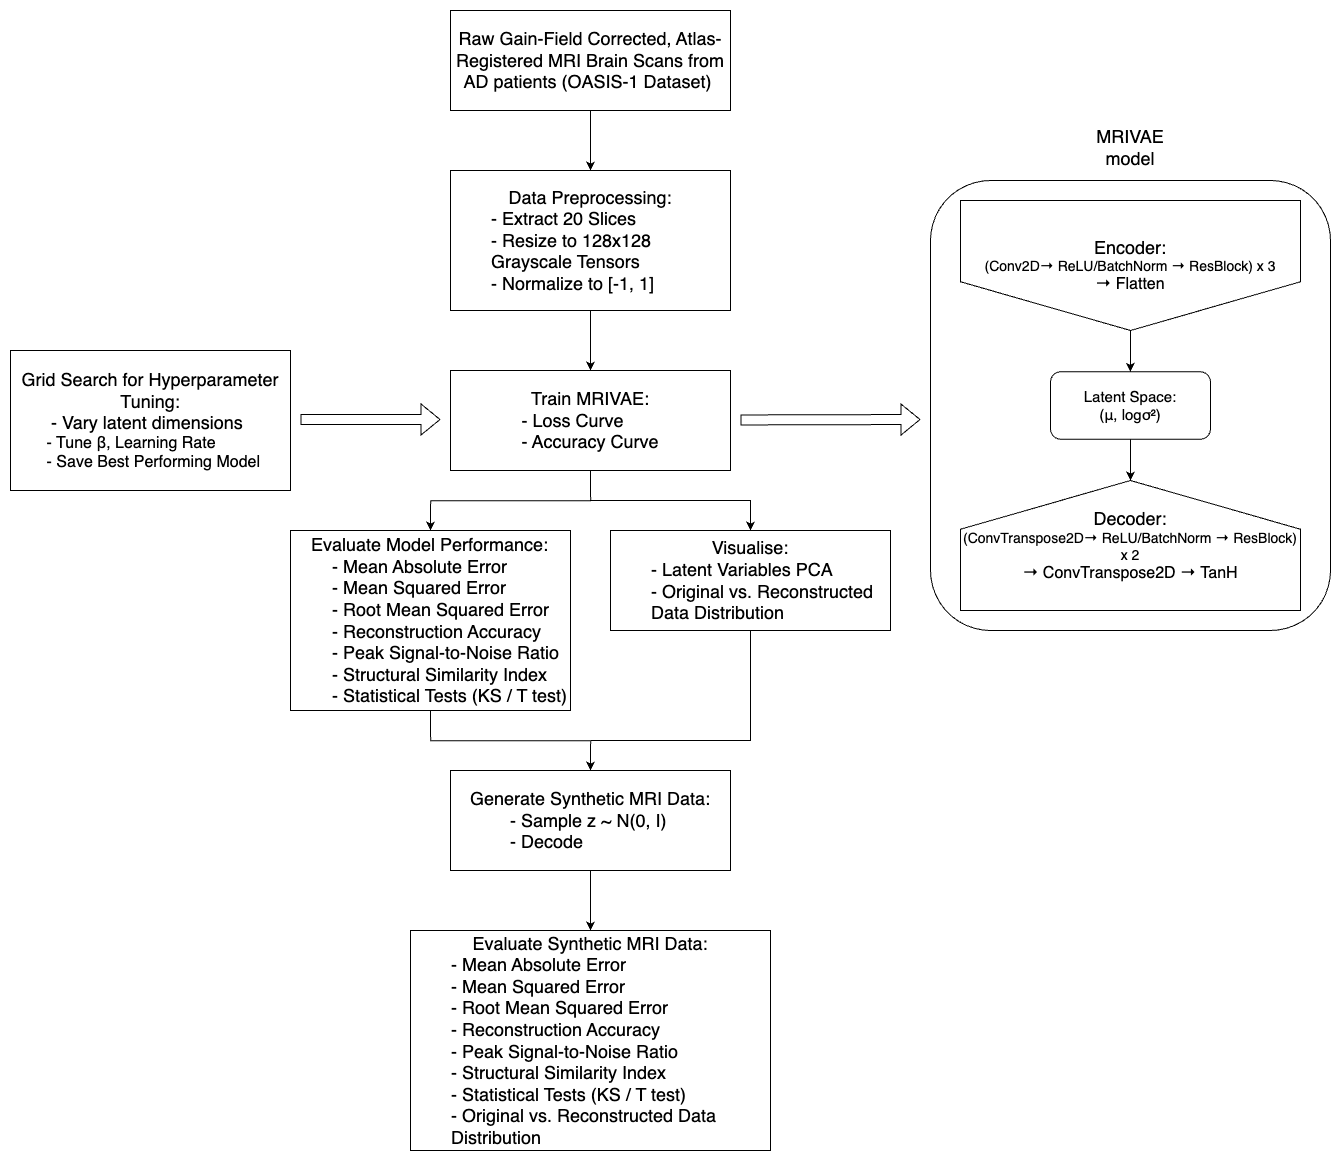

**adVAE Package Modules Structure:**

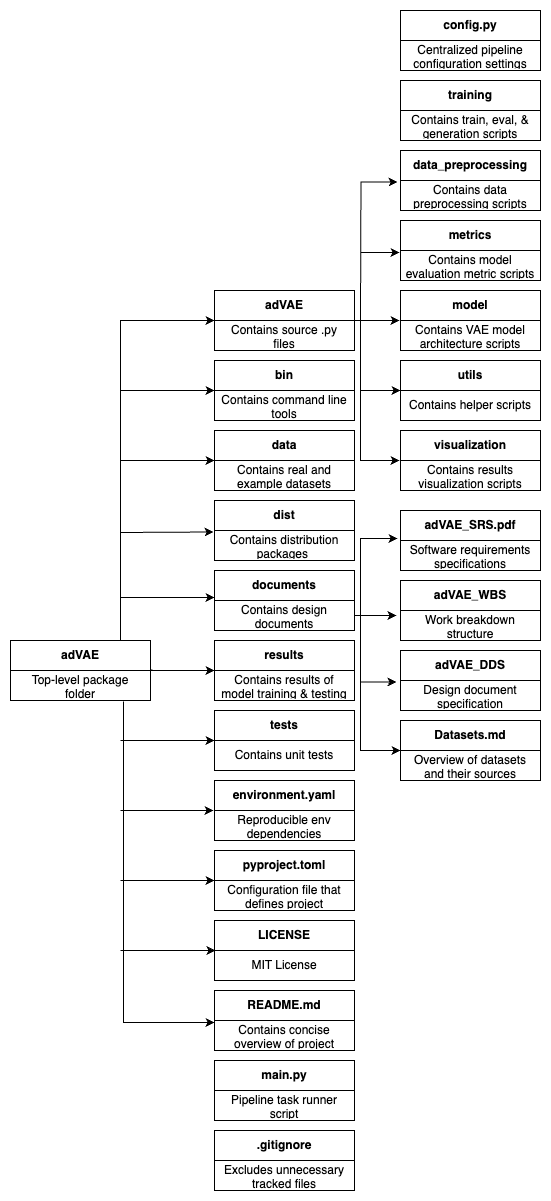

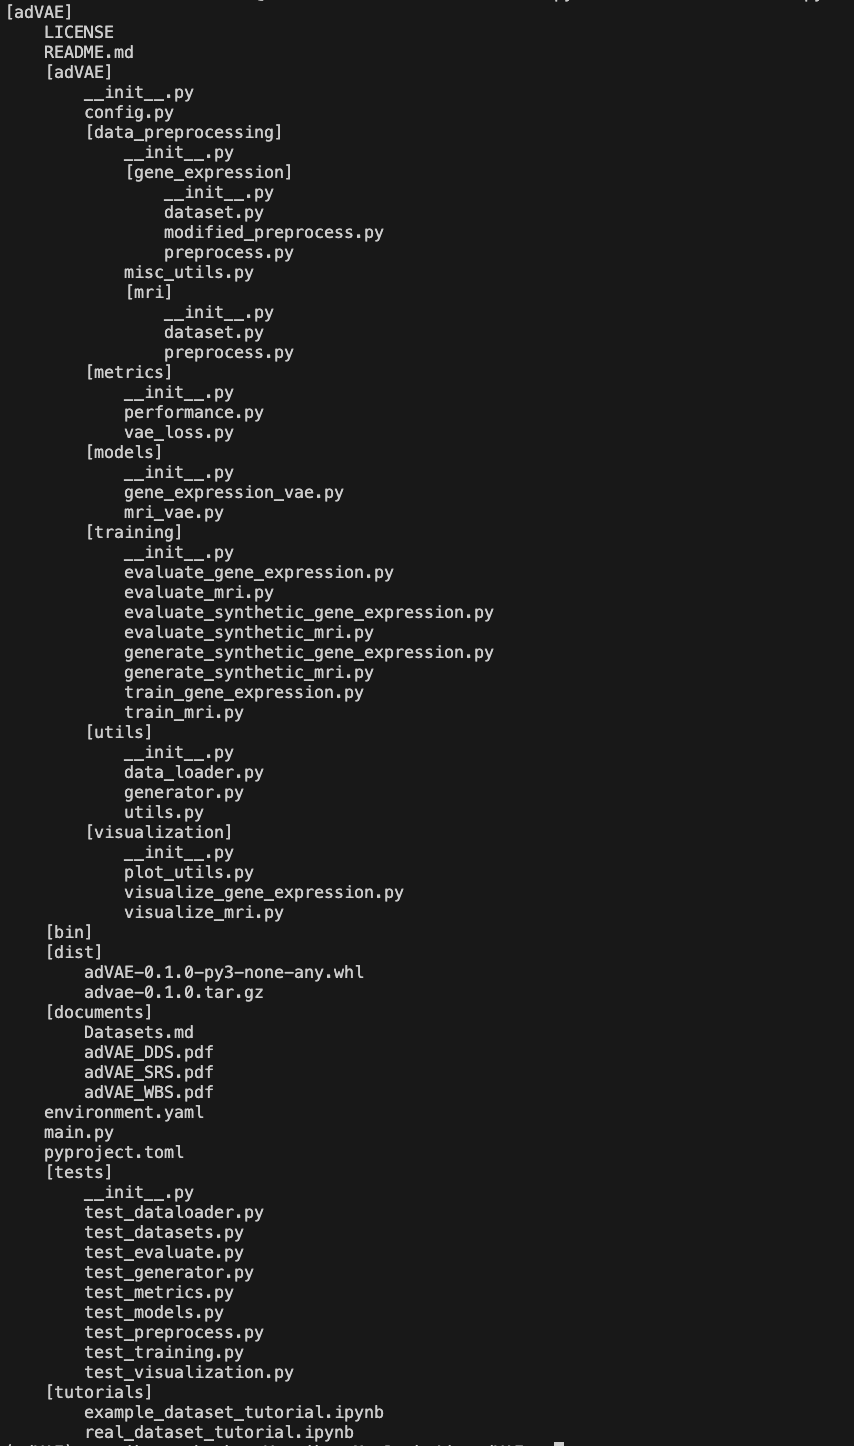

### Initialisatiion:

In [13]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import glob
import imageio.v3 as iio
sys.path.append(os.path.abspath(".."))

In [2]:
from adVAE.config import gene_expression, mri
from adVAE.training.train_gene_expression import train_model as train_gene
from adVAE.training.train_mri import train_model as train_mri
from adVAE.training.evaluate_gene_expression import evaluate_model as evaluate_gene
from adVAE.training.evaluate_mri import evaluate_model as evaluate_mri
from adVAE.visualization.visualize_gene_expression import visualize_latent_space as visualize_gene
from adVAE.visualization.visualize_mri import visualize_latent_space as visualize_mri
from adVAE.training.generate_synthetic_gene_expression import generate_and_save as generate_gene
from adVAE.training.generate_synthetic_mri import generate_and_save as generate_mri
from adVAE.data_preprocessing.gene_expression.preprocess import preprocess_pipeline as preprocess_gene
from adVAE.data_preprocessing.mri.preprocess import preprocess_pipeline as preprocess_mri
from adVAE.training.evaluate_synthetic_gene_expression import evaluate_synthetic_data as evaluate_synthetic_gene_data
from adVAE.training.evaluate_synthetic_mri import evaluate_synthetic_data as evaluate_synthetic_mri_data
from adVAE.utils.generator import generate_synthetic_data_from_posteriors
from adVAE.models.mri_vae import MRIVAE
from torch.utils.data import DataLoader
from adVAE.data_preprocessing.mri.dataset import MRIDataset

/opt/anaconda3/envs/adVAE/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/adVAE/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /opt/anaconda3/envs/adVAE/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <E459C462-F863-3A5A-AC9F-FD77B14BE845> /opt/anaconda3/envs/adVAE/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d")

### Gene Expression Pipeline:

In [8]:
print("Gene Expression Configuration:", gene_expression)
cfg = gene_expression
cfg = gene_expression.copy()
cfg["data_folder"] = "../data/AMP_AD_MSBB_MSSM"
cfg["data_path"] = f"../data/processed/X_pca_{timestamp}.npy"
cfg["weights_path"] = f"../results/gene_expression/model/vae_weights_{timestamp}.pth"
cfg["output_dir"] = "../results/gene_expression"
cfg["pca_model_path"] = f"../data/processed/pca_model_{timestamp}.pkl"
cfg["scaler_path"] = f"../data/processed/scaler_{timestamp}.pkl"

Gene Expression Configuration: {'hidden_dim': 32, 'latent_dim': 8, 'batch_size': 4, 'epochs': 100, 'lr': 0.001, 'num_samples': 5000, 'data_folder': 'data/AMP_AD_MSBB_MSSM', 'n_components': 0.95, 'scale_method': 'standard', 'visualize': False, 'aggregate_by_gene': True, 'data_path': 'data/processed/X_pca_2025-04-22.npy', 'weights_path': 'results/gene_expression/model/vae_weights_2025-04-22.pth', 'output_dir': 'results/gene_expression', 'beta': 0.1, 'pca_model_path': 'data/processed/pca_model_2025-04-22.pkl', 'scaler_path': 'data/processed/scaler_2025-04-22.pkl'}


**Data preprocessing:**

In [13]:
print("Preprocessing gene expression data...")
df, X_pca, scaler, pca_model = preprocess_gene(
    n_components=cfg["n_components"],
    data_folder=cfg["data_folder"],
    scale_method=cfg["scale_method"],
    aggregate_by_gene=cfg["aggregate_by_gene"],
)

# Saving the data
np.save(cfg["data_path"], X_pca)
with open(cfg["pca_model_path"], "wb") as f:
    pickle.dump(pca_model, f)
with open(cfg["scaler_path"], "wb") as f:
    pickle.dump(scaler, f)
print("Finished preprocessing and saving processed data.")

Preprocessing gene expression data...
Missing values filled: 0
Aggregated probe-level data to 21025 unique genes.
Saved raw CSV to data/processed/raw_gene_expression_2025-04-22.csv
Saved PCA-reduced data and models to data/processed
Finished preprocessing and saving processed data.


**Model Training:**

Epoch 1/100 - Loss: 1.2705 - Accuracy: 0.2639
Epoch 2/100 - Loss: 0.6730 - Accuracy: 0.3468
Epoch 3/100 - Loss: 0.6217 - Accuracy: 0.3548
Epoch 4/100 - Loss: 0.5957 - Accuracy: 0.3586
Epoch 5/100 - Loss: 0.5888 - Accuracy: 0.3613
Epoch 6/100 - Loss: 0.5775 - Accuracy: 0.3677
Epoch 7/100 - Loss: 0.5758 - Accuracy: 0.3671
Epoch 8/100 - Loss: 0.5713 - Accuracy: 0.3684
Epoch 9/100 - Loss: 0.5682 - Accuracy: 0.3718
Epoch 10/100 - Loss: 0.5664 - Accuracy: 0.3728
Epoch 11/100 - Loss: 0.5619 - Accuracy: 0.3748
Epoch 12/100 - Loss: 0.5635 - Accuracy: 0.3740
Epoch 13/100 - Loss: 0.5608 - Accuracy: 0.3782
Epoch 14/100 - Loss: 0.5594 - Accuracy: 0.3788
Epoch 15/100 - Loss: 0.5590 - Accuracy: 0.3809
Epoch 16/100 - Loss: 0.5603 - Accuracy: 0.3761
Epoch 17/100 - Loss: 0.5575 - Accuracy: 0.3786
Epoch 18/100 - Loss: 0.5573 - Accuracy: 0.3784
Epoch 19/100 - Loss: 0.5561 - Accuracy: 0.3781
Epoch 20/100 - Loss: 0.5547 - Accuracy: 0.3791
Epoch 21/100 - Loss: 0.5551 - Accuracy: 0.3810
Epoch 22/100 - Loss: 0

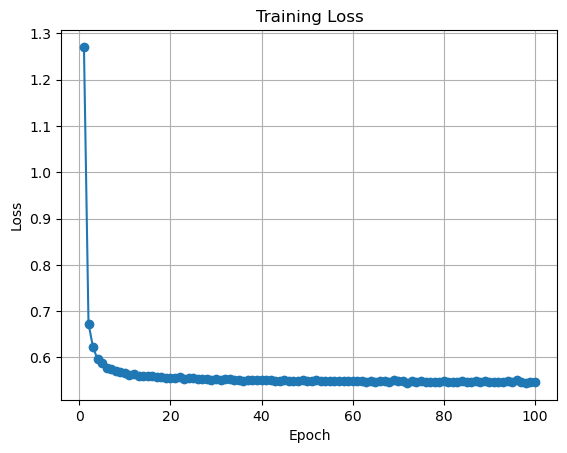

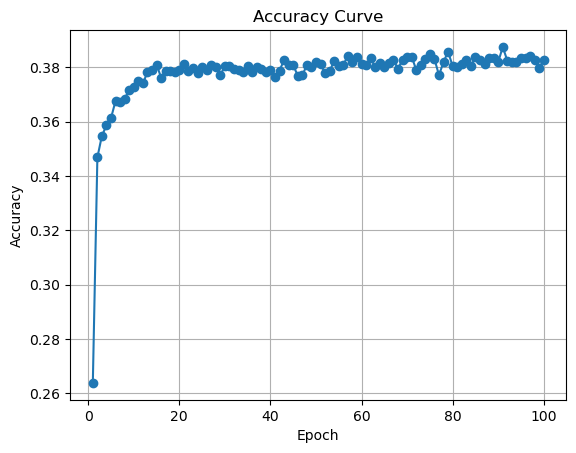

In [15]:
gene_model = train_gene(cfg)

**Model Evaluation:**

Evaluating performance of GeneExpressionVAE...
Reconstruction Accuracy (original space): 0.3929
Mean Absolute Error (original space): 3.3474
Mean Squared Error (original space): 34.8205
KS Test p-value: 1.415e-07 | Statistic: 0.0078
T-Test p-value: 0.5586 | Statistic: -0.5849
Mean Pearson Correlation across features: 0.9939
Reconstruction distribution plot saved to ../results/gene_expression/reconstruction_distribution_2025-04-22.png
Finished evaluating performance


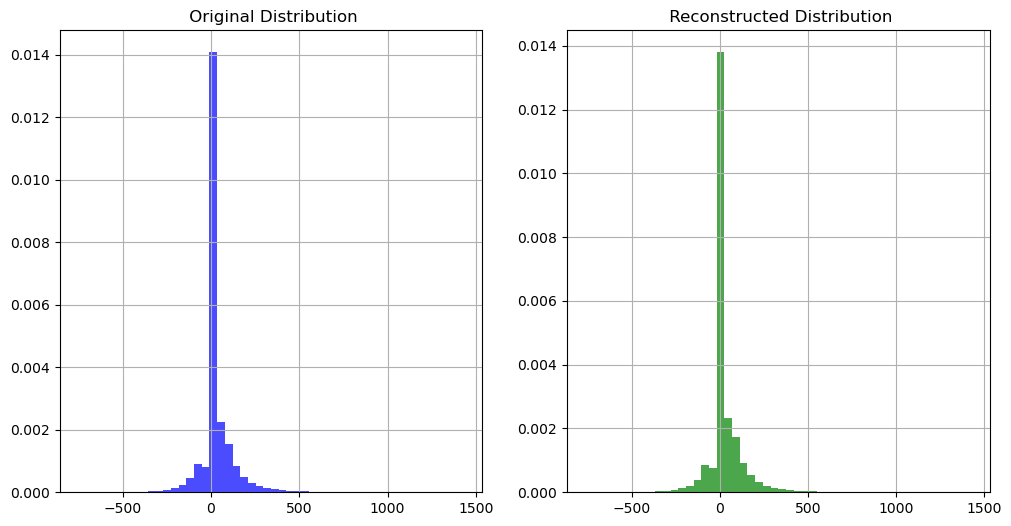

In [18]:
print("Evaluating performance of GeneExpressionVAE...")
evaluate_gene(cfg)
print(f"Finished evaluating performance")

**Model Visualisation:**

Visualizing latent space of GeneExpressionVAE...
Latent space plot saved to ../results/gene_expression/latent_pca_2025-04-22.png
Finished visualizing the latent space


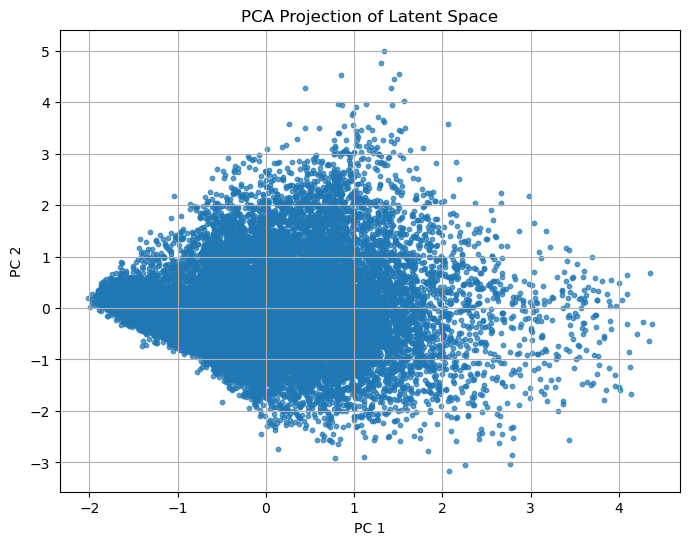

In [19]:
print("Visualizing latent space of GeneExpressionVAE...")
visualize_gene(cfg)
print(f"Finished visualizing the latent space")

**Synthetic Gene Expression Data Generation:**

In [20]:
print("Generating synthetic gene expression data...")
generate_gene(cfg)
print(f"Finished generating synthetic data")

Generating synthetic gene expression data...
Generated 5000 synthetic samples saved to ../results/gene_expression/synthetic_gene_expression_2025-04-22.tsv
Finished generating synthetic data


**Results:**

In [24]:
synthetic_path = f"../results/gene_expression/synthetic_gene_expression_{timestamp}.tsv"
gene_df = pd.read_csv(synthetic_path, sep="\t") # Load synthetic gene expression data
gene_df.head()

,k.all,k.in,k.out,k.diff,k.in.normed,k.all.normed,to.all,to.in,to.out,to.diff,to.in.normed,to.all.normed,standard.deviation
0,33.530939,7.760815,25.770124,-18.009310,0.007885,0.000614,100.524469,4.271655,96.252814,-91.981159,0.007777,0.001841,0.302923
1,108.024707,18.323748,89.700958,-71.377210,0.017916,0.001978,241.803502,16.078481,225.725021,-209.646541,0.015943,0.004428,0.255556
2,11.744746,6.248318,5.496428,0.751890,-0.002919,0.000215,63.852942,2.023554,61.829388,-59.805834,0.000256,0.001169,0.170060
3,140.674778,65.701992,74.972787,-9.270795,0.028505,0.002576,315.101449,69.804510,245.296939,-175.492430,0.027695,0.005770,0.386891
4,10.124775,4.380757,5.744018,-1.363261,0.008031,0.000185,54.392072,0.731661,53.660411,-52.928751,0.007418,0.000996,0.379782


**Synthetic Data Validation:**

Validating synthetic gene expression data...
Real data shape: (21025, 13) | Synthetic data shape: (5000, 13)
Mean Absolute Error: 0.4746
Mean Squared Error: 0.4918
Mean Pearson Correlation (mean vectors): 1.0000
KS Test: p = 0.05461, stat = 0.0059
T-Test: p = 0.5209, stat = 0.6420
Reconstruction distribution plot saved to ../results/gene_expression/synthetic_vs_real_distribution_2025-04-22.png


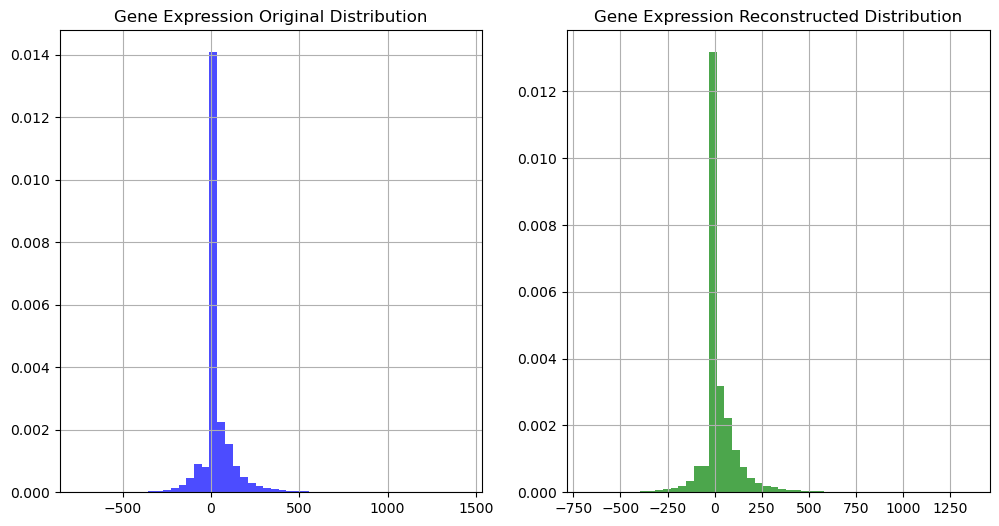

In [21]:
print("Validating synthetic gene expression data...")
synthetic_path = f"../results/gene_expression/synthetic_gene_expression_{timestamp}.tsv"
evaluate_synthetic_gene_data(cfg, synthetic_path)

**Discussion**:

- The gene expression VAE was trained on PCA-reduced AMP-AD MSBB RNA microarray data, retaining 95% of the original variance. Over 100 epochs, the model demonstrated stable convergence with the training loss settling around 0.5462 and reconstruction accuracy plateauing near 0.3826. 
- The reconstructed data closely mirrored the original distribution, as confirmed by visual histograms and quantitative metrics: a mean absolute error of 3.3474 and an average Pearson correlation of 0.9939. 
- Although the final reconstruction accuracy remains moderate, this is expected in high-dimensional biological data where small deviations can accumulate across many genes. Importantly, the model achieved a high mean Pearson correlation (0.9939) between the reconstructed and original data, indicating that it preserved the overall gene expression trends well.
- From a statistical standpoint, the reconstructed data did not show a significant mean difference from the original samples (T-test p = 0.5586), and the KS statistic was very small (0.0078), though statistically significant (p = 1.41e-07), implying a slight but consistent distributional deviation.
- The synthetic data generated from the trained VAE exhibited a good match with the real gene expression distribution. The mean absolute error between the real and synthetic data was low (0.47), and their mean vectors were perfectly correlated (Pearson r = 1.0), showing that the generator has managed to capture the global distribution of gene-level statistics effectively. 
- The KS test (p = 0.0546) and T-test (p = 0.5209) indicated no significant differences in distribution or central tendency, suggesting that the synthetic samples are statistically indistinguishable from the real data. 
- These results demonstrate that the model has successfully learned the underlying structure of gene expression data and, with access to more training data, holds strong potential for realistic data augmentation and simulation - particularly in biomedical contexts where sample sizes are limited.

### MRI Pipeline:

In [8]:
print("MRI Configuration:", mri)
cfg = mri
cfg["data_folder"] = "../data/OASIS_1"
cfg["data_path"] = f"../data/processed/mri_{timestamp}.pt"
cfg["weights_path"] = f"../results/mri/vae_weights_lat64_b0.1_lr0.001_{timestamp}.pth"
cfg["output_dir"] = "../results/mri"

MRI Configuration: {'latent_dim': 64, 'batch_size': 32, 'epochs': 10, 'lr': 0.001, 'data_folder': '../data/OASIS_1', 'data_path': '../data/processed/mri_2025-04-22.pt', 'weights_path': '../results/mri/model/vae_weights_lat64_b0.1_lr0.001_2025-04-22.pth', 'output_dir': '../results/mri', 'beta': 0.1, 'num_samples': 50}


**Data Preprocessing:**

In [5]:
print("Preprocessing MRI data...")
preprocess_mri()

Preprocessing MRI data...
OAS1_0003_MR1: extracted 20 slices
OAS1_0021_MR1: extracted 20 slices
OAS1_0022_MR1: extracted 20 slices
OAS1_0023_MR1: extracted 20 slices
OAS1_0028_MR1: extracted 20 slices
OAS1_0031_MR1: extracted 20 slices
OAS1_0035_MR1: extracted 20 slices
OAS1_0041_MR1: extracted 20 slices
OAS1_0042_MR1: extracted 20 slices
OAS1_0046_MR1: extracted 20 slices
OAS1_0052_MR1: extracted 20 slices
OAS1_0053_MR1: extracted 20 slices
OAS1_0056_MR1: extracted 20 slices
OAS1_0060_MR1: extracted 20 slices
OAS1_0066_MR1: extracted 20 slices
OAS1_0073_MR1: extracted 20 slices
OAS1_0082_MR1: extracted 20 slices
OAS1_0084_MR1: extracted 20 slices
OAS1_0094_MR1: extracted 20 slices
OAS1_0098_MR1: extracted 20 slices
OAS1_0115_MR1: extracted 20 slices
OAS1_0120_MR1: extracted 20 slices
OAS1_0122_MR1: extracted 20 slices
OAS1_0123_MR1: extracted 20 slices
OAS1_0124_MR1: extracted 20 slices
OAS1_0134_MR1: extracted 20 slices
OAS1_0137_MR1: extracted 20 slices
OAS1_0142_MR1: extracted 20 s

**Model Training:**

Training MRIVAE on MRI data...
Epoch 1/10 | Loss: 6793808.4063 | Accuracy: 0.2446
Epoch 2/10 | Loss: 1080.6302 | Accuracy: 0.4946
Epoch 3/10 | Loss: 1804.8985 | Accuracy: 0.4917
Epoch 4/10 | Loss: 921.4685 | Accuracy: 0.5324
Epoch 5/10 | Loss: 905.8802 | Accuracy: 0.5684
Epoch 6/10 | Loss: 750.7425 | Accuracy: 0.5869
Epoch 7/10 | Loss: 700.3869 | Accuracy: 0.5997
Epoch 8/10 | Loss: 1041.7654 | Accuracy: 0.5928
Epoch 9/10 | Loss: 827.3449 | Accuracy: 0.5741
Epoch 10/10 | Loss: 634.5533 | Accuracy: 0.6100
Model weights saved to ../results/mri/vae_weights_lat64_b0.1_lr0.001_2025-04-22.pth
Loss curve saved to ../results/mri/loss_curve_2025-04-22.png
Accuracy curve saved to ../results/mri/accuracy_curve_2025-04-22.png
Saved processed data to ../results/mri


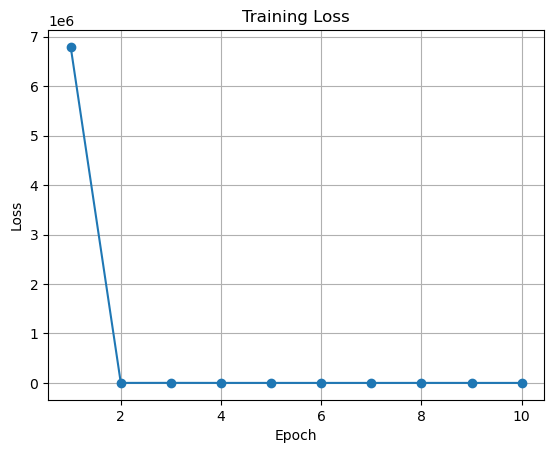

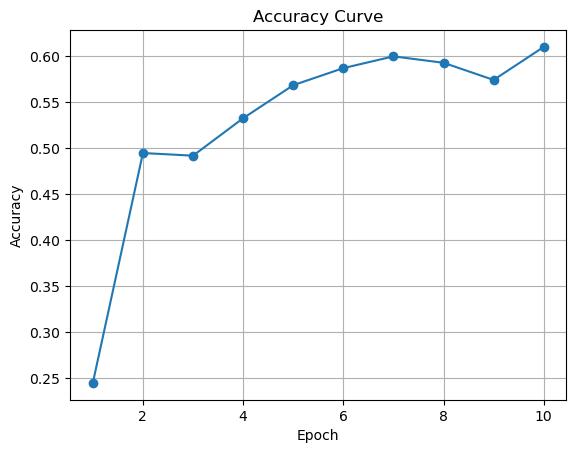

In [6]:
print("Training MRIVAE on MRI data...")
train_mri(data_path=cfg["data_path"], latent_dim=cfg["latent_dim"], batch_size=cfg["batch_size"],
          epochs=cfg["epochs"], lr=cfg["lr"], output_dir=cfg["output_dir"])
print(f"Saved processed data to {cfg['output_dir']}")

**Model Evaluation:**

Evaluating performance of MRIVAE...
Reconstruction Accuracy: 0.6138
Mean SSIM: 0.5869
Mean PSNR: 16.6856
Mean MSE: 0.0217
Mean RMSE: 0.1469
Mean MAE: 0.1037
t-test: stat = 194.5314, p = 0.0000e+00
KS-test: stat = 0.1654, p = 0.0000e+00
Reconstruction distribution plot saved to results/mri/reconstruction_distribution_2025-04-22.png
Finished evaluating performance


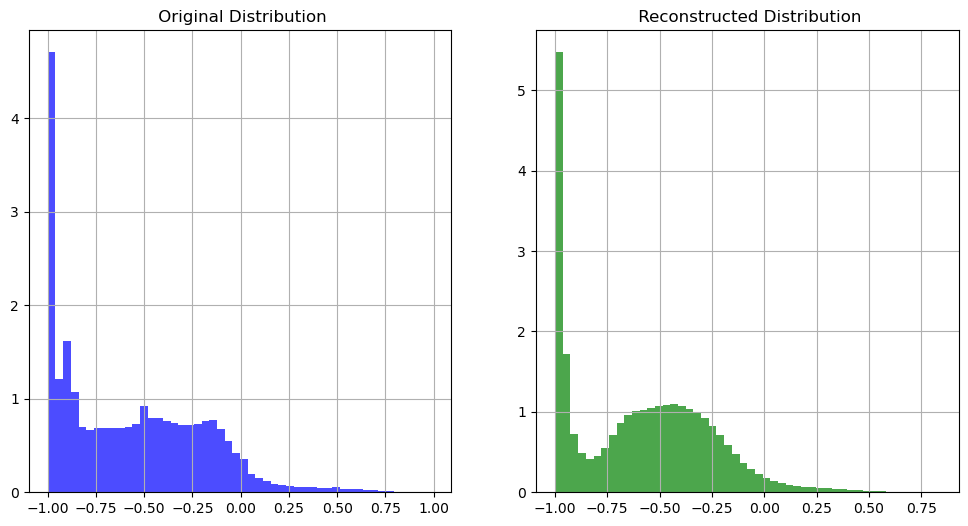

In [9]:
print("Evaluating performance of MRIVAE...")
evaluate_mri(weights_path=cfg["weights_path"], data_path=cfg["data_path"])
print(f"Finished evaluating performance")

**Model Visualisation:**

Visualizing latent space of MRIVAE...
Latent space plot saved to results/mri/latent_pca.png
Finished visualizing the latent space


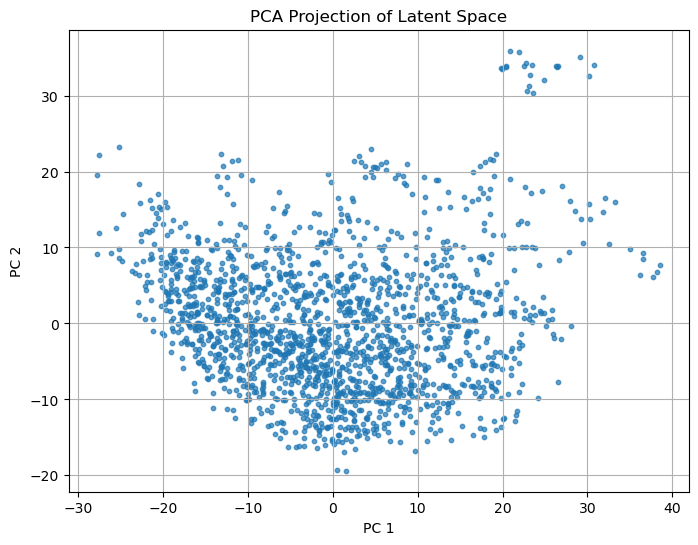

In [10]:
print("Visualizing latent space of MRIVAE...")
visualize_mri(weights_path=cfg["weights_path"], data_path=cfg["data_path"], latent_dim=cfg["latent_dim"])
print(f"Finished visualizing the latent space")

**Synthetic MRI Data Generation:**

In [11]:
print("Generating synthetic MRI data...")
generate_mri(weights_path=cfg["weights_path"], latent_dim=cfg["latent_dim"], num_samples=50,
             output_dir=os.path.join(cfg["output_dir"], "synthetic_gifs"), data_path=cfg["data_path"])
print(f"Finished generating synthetic data")

Generating synthetic MRI data...
Saved 50 synthetic MRI GIFs to ../results/mri/synthetic_gifs
Finished generating synthetic data


**Results:**

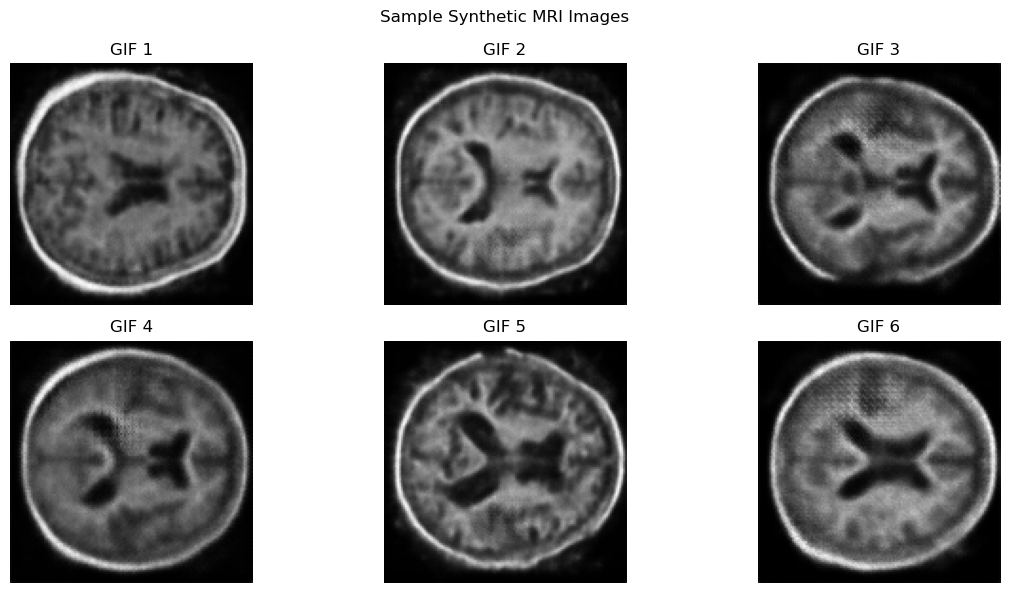

In [17]:
gif_paths = sorted(glob.glob("../results/mri/synthetic_gifs/*.gif"))[:6]

plt.figure(figsize=(12, 6))
for i, gif_path in enumerate(gif_paths):
    image = iio.imread(gif_path)

    if image.ndim == 4: 
        image = image[0]
    if image.ndim == 3 and image.shape[-1] == 3: 
        image = np.mean(image, axis=-1)

    plt.subplot(2, 3, i + 1)
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.title(f"GIF {i+1}")

plt.suptitle("Sample Synthetic MRI Images")
plt.tight_layout()
plt.show()

**Synthetic Data Validation:**

Validating synthetic MRI data...
Real data shape: (1740, 128, 128) | Synthetic data shape: (50, 128, 128)
Mean Absolute Error: 0.0404
Mean Squared Error: 0.0031
Root Mean Squared Error: 0.0556
Mean PSNR: 11.4376
Mean SSIM: 0.3617
KS Test: p = 0, stat = 0.1654
T-Test: p = 0, stat = 52.7103
Reconstruction distribution plot saved to ../results/mri/synthetic_vs_real_distribution_2025-04-22.png


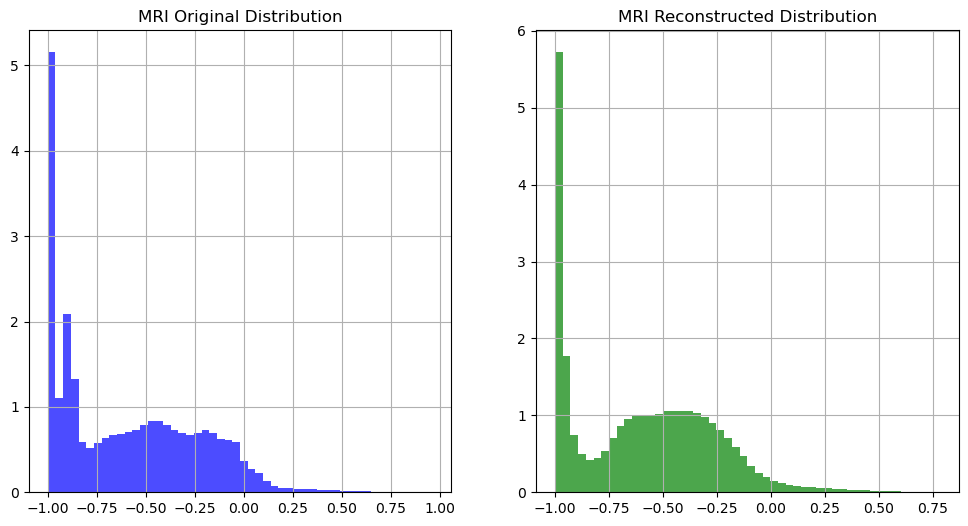

In [15]:
print("Validating synthetic MRI data...")
model = MRIVAE(latent_dim=cfg["latent_dim"]) # Load model
model.load_state_dict(torch.load(cfg["weights_path"], map_location="cpu"))
model.eval()

dataset = MRIDataset(cfg["data_path"]) # Load real data
loader = DataLoader(dataset, batch_size=cfg.get("batch_size", 32), shuffle=True)

synthetic_np = generate_synthetic_data_from_posteriors( # Generate synthetic data using learned posterior
    model,
    dataloader=loader,
    num_samples=cfg["num_samples"],
    device="cpu"
)

synthetic_tensor = torch.tensor(synthetic_np, dtype=torch.float32) # Convert and evaluate
evaluate_synthetic_mri_data(cfg, synthetic_tensor)

**Discussion:**

- The MRI VAE was trained on OASIS-1 MRI slices obtained from Gain-field corrected, atlas-registered average brain scans images (.img). Over 10 epochs, the model demonstrated stable convergence with the training loss settling around 634.5533 and reconstruction accuracy plateauing near 0.6100. 
- The structural similarity index (SSIM) of 0.5869 and peak signal-to-noise ratio (PSNR) of 16.6856 dB indicate moderately good visual similarity between the original and reconstructed images, although there’s room for improvement. 
- Additionally, the mean squared error (MSE) and root mean squared error (RMSE) were 0.0217 and 0.1469, respectively, with a mean absolute error (MAE) of 0.1037 - all of which are reasonably low. 
- Statistical tests further support the divergence between original and reconstructed distributions, with both the t-test and KS-test yielding highly significant results (p ~ 0), indicating that despite good reconstruction, the model still introduces detectable differences in pixel distributions.
- While these synthetic MRI images were generated from learned posterior distributions, they are not yet as sharp or structured as the reconstructions. 
- The MAE of 0.0404, MSE of 0.0031, and RMSE of 0.0556 are all impressively low, but this is probably largely due to the overall pixel value range rather than perfect structural fidelity. 
- The PSNR drops to 11.44 dB, and the SSIM falls to 0.3617, indicating a noticeable decline in perceptual quality and spatial coherence compared to the original MRI slices. 
- Moreover, statistical tests again show strong differences from the real data, with a KS statistic of 0.1654 and t-statistic of 52.71, both highly significant. These results reflect that while the generated MRIs preserve broad intensity distributions, finer structural details are not yet convincingly realistic.
- This initial performance is still encouraging as it demonstrates that the model has learned meaningful patterns and can generate plausible outputs. With more training data and additional tuning, the synthetic MRI generator shows strong potential for use in data augmentation or simulation tasks in low-data regimes.

### Future Directions:

The project aims to expand support for additional biomedical data types, starting with a dedicated EEG pipeline. Future updates will also integrate proper train-validation-test splits, introduce advanced evaluation techniques, and explore more expressive VAE variants to enhance the accuracy and utility of generated synthetic data.